In [1]:
import json
import numpy as np
import os
import random
import pylab
import cv2

from PIL import Image, ImageDraw

from matplotlib import pyplot as plt
from matplotlib import animation as animation

### Visualizing glimpses

In [2]:
def create_gif(img, pred, label, locs, num_glimpses, explore_steps, patch_size, colors, resize_factor, out_file):
    """Create GIF file with the sequence of glimpses produced by the model.

    Args:
        img (PIL Image): sample image
        pred (list): Predicted labels
        label (list): GT labels
        locs (list): Glimpse locations produced by the model
        num_glimpses (int): Number of glimpses taken before each prediction
        patch_size (int): Size of the glimpses
        colors (list): List of colors used for visualizing the glimpses
        resize_factor (int): Resize factor for visualization
        out_file (str): Where to save the image and gif
    """
    # create draw object
    gif_image = img.copy()
    line_draw = ImageDraw.Draw(gif_image)

    frames = []
    for i in range(len(locs)):
        # get color for current glimpse
        if i < explore_steps:
            current_color = "white"
        else:
            current_color = colors[(i-explore_steps)//num_glimpses]
        point = locs[i]

        if i != 0:
            # All frames share the drawing of the line connecting glimpses
            line_draw.line((*prev_point, *point), fill="white")

        # In each frame only one glimpse will be visible, 
        frame = gif_image.copy()
        frame_draw = ImageDraw.Draw(frame)

        # draw center glimpse point
        frame_draw.point(point, fill=current_color)

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.ellipse(shape, outline=current_color)

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        frame_draw.rectangle(shape, outline=current_color)

        # update previous point
        prev_point = point
        
        # save frame
        frames.append(frame)

    # Set the initial frame
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], animated=True)
    ax.set_title(f"Prediction: {pred} | GT: {label}")
    ax.axis(False)

    def update(i):
        im.set_array(frames[i])
        return im

    # Create the animation (GIF)
    animation_fig = animation.FuncAnimation(
        fig, update, frames=len(frames), interval=400, blit=False, repeat_delay=200)
    animation_fig.save(out_file + ".gif")


def visualize_glimpses(sample, patch_size, num_glimpses, explore_steps, save=False, out_file=None):
    """ Visualize sample results: Predictions and image/gif showing the glimpses taken
        by the model.
    
    Args:
        sample (dict): Sample results
        patch_size (int): Size of the glimpses
        save (bool): Wether to save the glimpse image/gif
        out_file (str): Where to save the image and gif

    Returns:
        PIL Image: Image containing all the glimpse            
    """
    pylab.ioff() # Prevent im.show() from showing all the images while running
    
    # Number of correctly pred
    pred_digits = np.array(sample["pred"])[(np.array(sample["pred"]) != -100)]
    pred_digits = [i if i != 0 else "end" for i in pred_digits]
    correct_num_digits = (np.array(sample["pred"]) != -100).sum()
    gt_labels = np.array(sample['labels'])[(np.array(sample["labels"]) != -100)]
    gt_labels = [i if i != 0 else "end" for i in gt_labels]

    # load image and normalize
    img = np.array(sample["pixel_values"])
    img = (img * 0.3081) + 0.1307
    img = np.repeat(img, 3, axis=0)
    img = np.moveaxis(img, 0, 2)
    img = Image.fromarray(np.uint8(img*255))
    w, h = img.size
    
    # Resize to be visible
    resize_factor = 5
    img = img.resize((w*resize_factor, h*resize_factor))
    w, h = img.size

    # convert glimpse locations to pixel space
    locs = [[(i + 1)/2 * w, (j + 1)/2 * h] for i,j in sample["locs"]]
    locs = locs[:correct_num_digits*num_glimpses]

    # colors to distinguish digit predictions
    colors = ["red", "blue", "yellow", "green", "orange"]

    # create draw object
    draw_img = img.copy()
    draw = ImageDraw.Draw(draw_img)

    for i in range(len(locs)):
        # get color for current glimpse
        if i < explore_steps:
            current_color = "white"
        else:
            current_color = colors[(i-explore_steps)//num_glimpses]
        
        # draw center glimpse point
        point = locs[i]
        draw.point(point, fill=current_color)

        if i != 0:
            # Line joining past and current glimpse
            draw.line((*prev_point, *point), fill="white")

        # draw an small circle around the center glimpse point (for better visibility)
        radius = 5
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.ellipse(shape, outline=current_color)

        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.rectangle(shape, outline=current_color)
        
        scale_factor = 2
        # draw the area covered by the glimpse
        radius = patch_size/2 * resize_factor * scale_factor
        shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
        draw.rectangle(shape, outline=current_color)

        # update previous point
        prev_point = point
        
    if save:
        # Save image
        fig, ax = plt.subplots()
        ax.imshow(draw_img)
        ax.set_title(f"Prediction: {pred_digits} | GT: {gt_labels}")
        ax.axis(False)
        fig.savefig(out_file + ".png", bbox_inches='tight')
        
        # Create and save gif
        create_gif(img, pred_digits, gt_labels, locs, num_glimpses, explore_steps, patch_size, colors, resize_factor, out_file)

    # Clean plots
    plt.close(fig)
    pylab.ion()
    
    return draw_img


In [3]:
#ckpt_dir = "/data/users/jmorales/model_files/Exp2/LSTM_baseline"
#ckpt_dir = "/data/users/jmorales/model_files/Exp2/TrXL"
#ckpt_dir = "/data/users/jmorales/model_files/Exp2/GPT2"
#ckpt_dir = "/data/users/jmorales/model_files/Exp2/GTrXL_512"
ckpt_dir = "/data/users/jmorales/model_files/Exp2/GTrXL_768"
#ckpt_dir = "/data/users/jmorales/model_files/Exp2/GTrXL_1024"

res_file = [i for i in os.listdir(ckpt_dir) if "results.json" in i][0]
res_file = os.path.join(ckpt_dir, res_file)

with open(res_file, "r") as f:
    results = json.load(f)

In [4]:
good = [i for i in results if i["all_correct"]]
bad = [i for i in results if not i["all_correct"]]

/tmp/ipykernel_2232423/3687058523.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


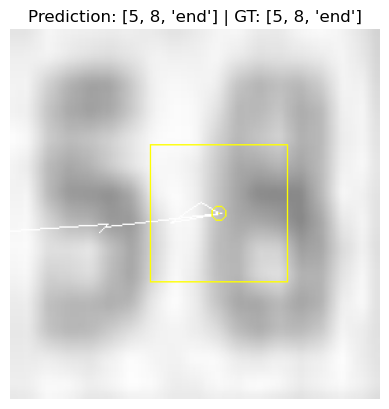

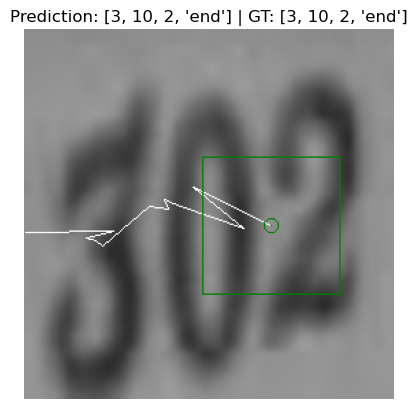

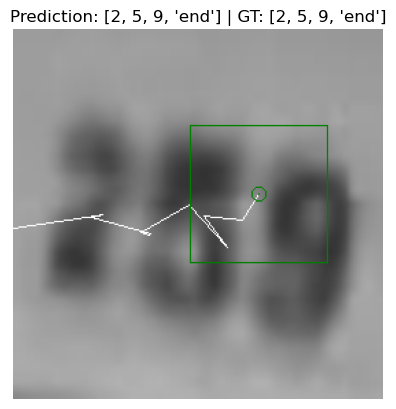

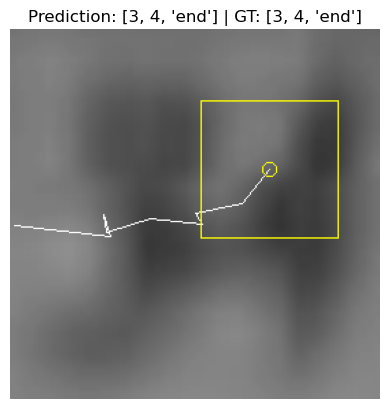

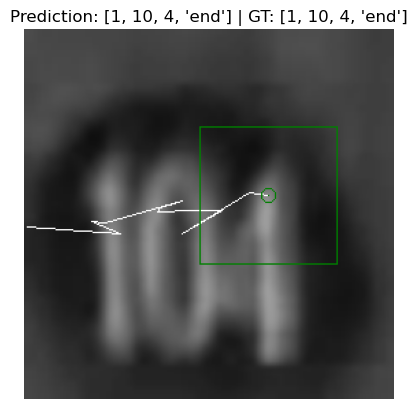

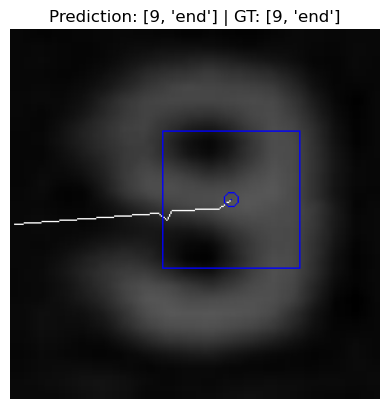

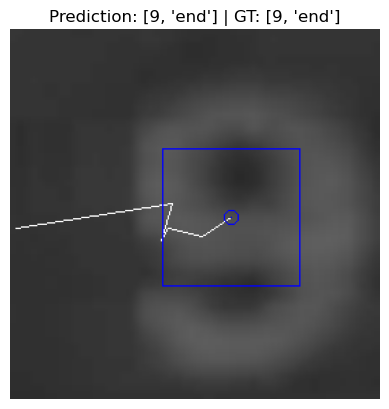

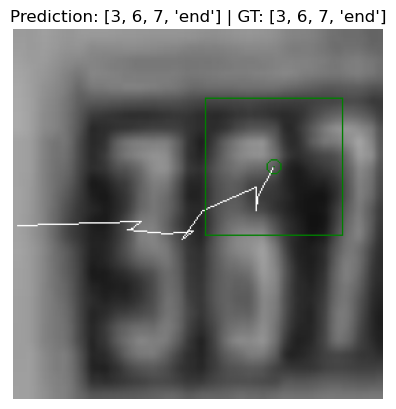

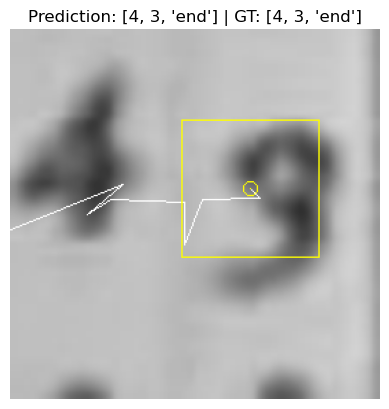

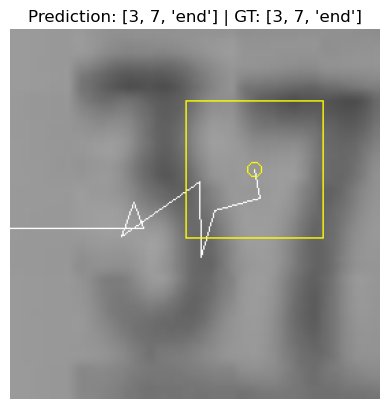

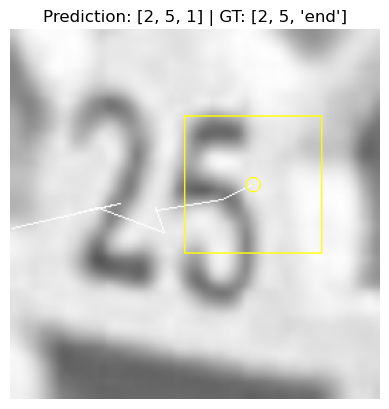

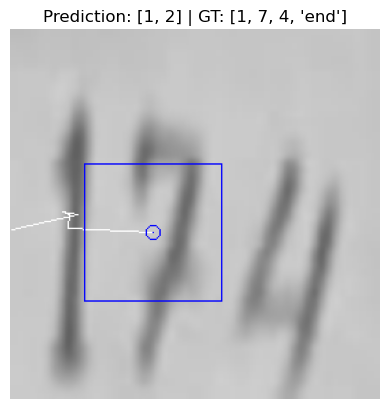

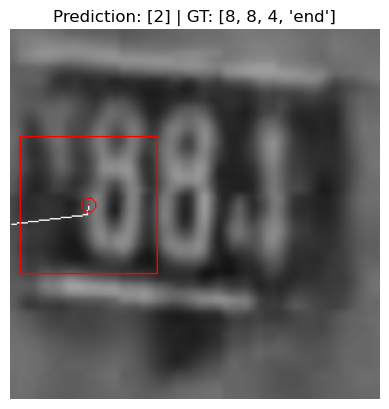

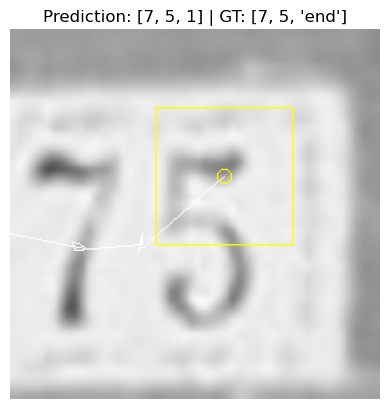

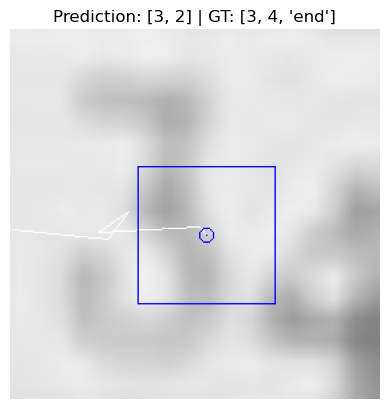

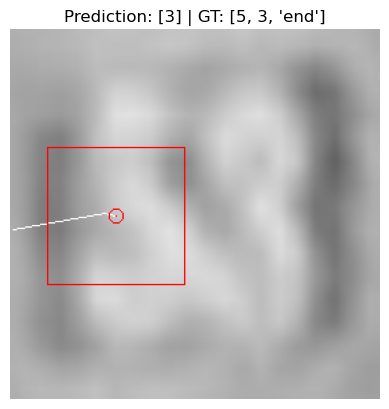

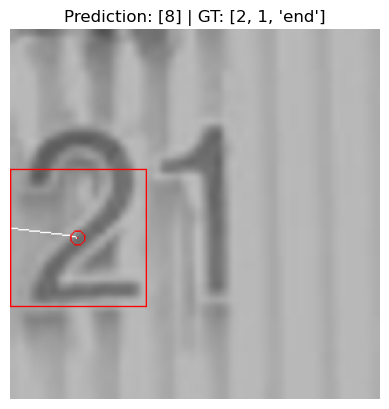

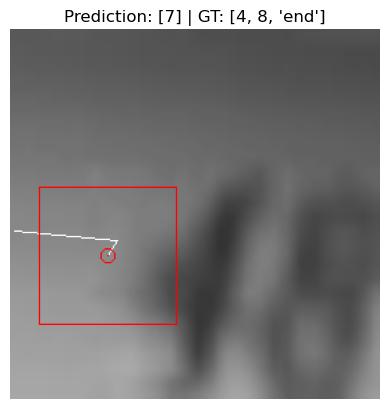

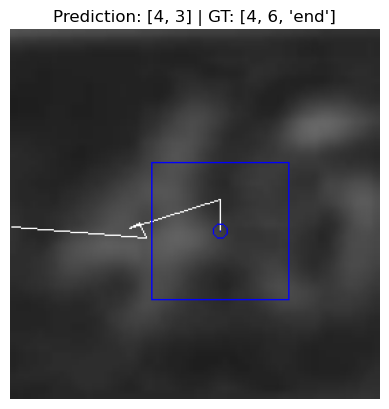

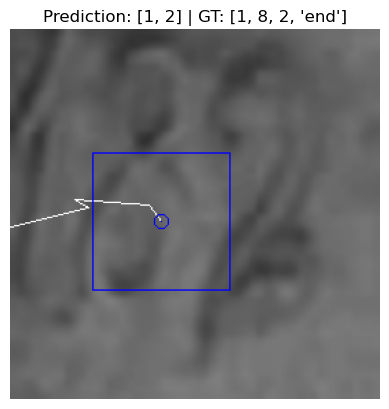

In [5]:
for samples, label in zip([good, bad], ["correct", "wrong"]):
    samples = random.sample(samples, 10)
    for i, sample in enumerate(samples):
        visualize_glimpses(
            sample, 
            patch_size=20, 
            num_glimpses=3,
            explore_steps=0,
            save=True, 
            out_file=f"../plots/Experiment2/GTrXL768_{label}_{i}"
            )

In [33]:
def visualize_glimpses(sample, patch_size, num_glimpses, explore_steps, save=False, out_file=None):
    """ Visualize sample results: Predictions and image/gif showing the glimpses taken
        by the model.
    
    Args:
        sample (dict): Sample results
        patch_size (int): Size of the glimpses
        save (bool): Wether to save the glimpse image/gif
        out_file (str): Where to save the image and gif

    Returns:
        PIL Image: Image containing all the glimpse            
    """
    pylab.ioff() # Prevent im.show() from showing all the images while running
    
    # Number of correctly pred
    pred_digits = np.array(sample["pred"])[(np.array(sample["pred"]) != -100)]
    pred_digits = [i if i != 0 else "end" for i in pred_digits]
    pred_digits = [i if i != 10 else 0 for i in pred_digits]
    correct_num_digits = (np.array(sample["pred"]) != -100).sum()
    gt_labels = np.array(sample['labels'])[(np.array(sample["labels"]) != -100)]
    gt_labels = [i if i != 0 else "end" for i in gt_labels]
    gt_labels = [i if i != 10 else 0 for i in gt_labels]

    # load image and normalize
    img = np.array(sample["pixel_values"])
    img = (img * 0.3081) + 0.1307
    img = np.repeat(img, 3, axis=0)
    img = np.moveaxis(img, 0, 2)
    img = np.uint8(img*255)
    w, h, c = img.shape
    
    # convert glimpse locations to pixel space
    locs = [[(i + 1)/2 * w, (j + 1)/2 * h] for i,j in sample["locs"]]
    locs = locs[:correct_num_digits*num_glimpses]

    # create draw object
    high_res_img = np.full(img.shape, fill_value=-1)
    low_res_img = np.full_like(img, fill_value=-1)

    points = []
    for i in range(len(locs)):        
        # draw center glimpse point
        point = locs[i]
        points.append(point)

        # high res region
        radius = patch_size/2
        x1, y1, x2, y2 = int(point[0]-radius), int(point[1]-radius), int(point[0]+radius), int(point[1]+radius)
        high_res_img[y1:y2, x1:x2, :] = img[y1:y2, x1:x2, :]
        
        # high res region
        scale_factor = 2
        radius = patch_size/2 * scale_factor
        x1, y1, x2, y2 = int(point[0]-radius), int(point[1]-radius), int(point[0]+radius), int(point[1]+radius)
        low_res_img[y1:y2, x1:x2, :] = img[y1:y2, x1:x2, :]
    
    # reduce resolution of low_res_img
    low_res_img = cv2.resize(low_res_img, dsize=(int(w//2), int(h//2)))
    low_res_img = cv2.resize(low_res_img, dsize=(w, h))
        
    new_img_array = low_res_img    
    new_img_array[high_res_img != -1] = high_res_img[high_res_img != -1]
    new_img = Image.fromarray(new_img_array)
    
    
    scale_factor = 5
    new_img = new_img.resize((w*scale_factor, h*scale_factor))
    points = [(i[0]*scale_factor, i[1]*scale_factor) for i in points]
    
    # Draw glimpse track
    draw = ImageDraw.Draw(new_img)
    prev_point = None
    for i, point in enumerate(points):
        if i == 0:
            # draw an small circle around the center glimpse point (for better visibility)
            radius = 3
            shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
            draw.ellipse(shape, outline="green", fill="green")
        else:
            # draw an small circle around the center glimpse point (for better visibility)
            radius = 2
            shape = [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)]
            draw.ellipse(shape, outline="red", fill="red")
            
            # Line joining past and current glimpse
            draw.line((*prev_point, *point), fill="red")
        
        prev_point = point
    
    
    # Save image
    fig, ax = plt.subplots()
    ax.imshow(new_img)
    ax.set_title(f"Prediction: {pred_digits} | GT: {gt_labels}", fontsize=20, y=1.025)
    #ax.axis(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.savefig(out_file + ".png", bbox_inches='tight')
        

    # Clean plots
    plt.close(fig)
    pylab.ion()
    
    return new_img


In [34]:
for samples, label in zip([good, bad], ["correct", "wrong"]):
    samples = random.sample(samples, 10)
    for i, sample in enumerate(samples):
        visualize_glimpses(
            sample, 
            patch_size=20, 
            num_glimpses=3,
            explore_steps=0,
            save=True, 
            out_file=f"../plots/Experiment2/RevealGTrXL768_{label}_{i}"
            )